In [1]:
import csv
import collections

from argparse import ArgumentParser
from sklearn.model_selection import train_test_split
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import os


from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.sequence import pad_sequences
from transformers import BertTokenizer, BertModel, BertForSequenceClassification
import torch


In [2]:

labels = []
texts = []

# read full dataset file
with open("../articles.csv",  "r", encoding='utf-8',) as csvfile:
    reader = csv.reader(csvfile, delimiter=';', quotechar='\'')
    for row in reader:
        labels.append(row[0])
        texts.append(row[1])

tr_Df=pd.concat([pd.Series(texts, name="Text"), pd.Series(labels,name='Label')], axis=1)

features_path="features"
if not os.path.exists(features_path):
    os.mkdir(features_path)
tr_Df.Label.to_csv(features_path+os.sep+"y_labels.out")


Inland - Internal Affairs

Etat - Budget and Statistics

Panorama - Popular?

Web - IT 

Wirtschaft - Economy

Wissenschaft - Science

#### Plot class distribution

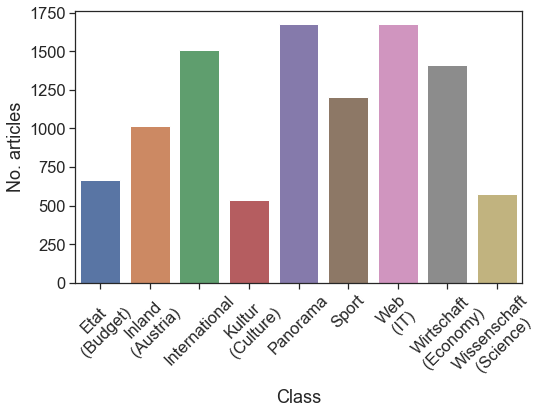

In [62]:
import textwrap
class_distributions=tr_Df.groupby("Label").count()
class_distributions["Label"]=class_distributions.index
class_distributions.columns=["No. articles", "Class"]
class_distributions.Class.replace("Etat", "Etat     (Budget)", inplace=True)
class_distributions.Class.replace("Web", "Web        (IT)", inplace=True)
class_distributions.Class.replace("Inland", "Inland   (Austria)", inplace=True)
#class_distributions.Class.replace("International", "Internat.", inplace=True)
class_distributions.Class.replace("Wirtschaft", "Wirtschaft (Economy)", inplace=True)
class_distributions.Class.replace("Kultur", "Kultur   (Culture)", inplace=True)

class_distributions.Class.replace("Wissenschaft", "Wissenschaft (Science)", inplace=True)
sns.set(rc={'figure.figsize':(8,5)},font_scale=1.5)
sns.set_style("ticks")

ax=sns.barplot(data=class_distributions, x="Class", y="No. articles")
ax.set_xticklabels([textwrap.fill(e, 13) for e in class_distributions.Class.unique()], rotation=45)
plt.show()
figure = ax.get_figure()    
#figure.savefig('../visualizations/class_distribution.png', dpi=500,bbox_inches='tight')

#### Plot Text length distribution

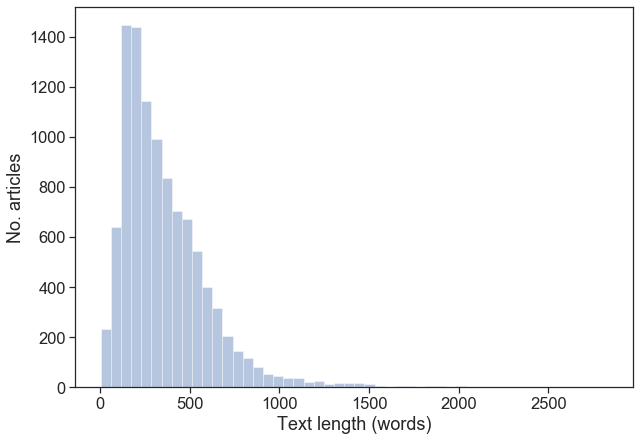

In [72]:
tr_Df['Text Length']=tr_Df['Text'].str.split().str.len()
#tr_Df = tr_Df[tr_Df['Text Length'] != tr_Df['Text Length'].max()]
sns.set(rc={'figure.figsize':(10,7)}, font_scale=1.5)
sns.set_style("ticks")
ax=sns.distplot(tr_Df["Text Length"], kde=False, color="b")
#ax.set_xticks(range(0,3250,250))
ax.set_ylabel("No. articles")
ax.set_xlabel("Text length (words)")
figure = ax.get_figure()    
#figure.savefig('../visualizations/text_length_distribution.png', dpi=500,bbox_inches='tight')

In [73]:
#tr_Df = tr_Df[tr_Df['No. words'] != tr_Df['No. words'].max()]
tr_Df.Label.unique()

array(['Etat', 'Inland', 'International', 'Kultur', 'Panorama', 'Sport',
       'Web', 'Wirtschaft', 'Wissenschaft'], dtype=object)

# BERT

## Generate embeddings (first and last segment)

#### for 4 different settings, both multilingual BERT and German BERT, as well as taking first 512 tokens of each article and last 512



In [2]:
def genIdMask(data, truncating, whichBert):
    sms = data.Text.values
    sms = ["[CLS] " + sm + " [SEP]" for sm in sms]
    model_name = whichBert
    tokenizer = BertTokenizer.from_pretrained(model_name)

    tokenized_texts = [tokenizer.tokenize(sm) for sm in sms]

    MAX_LEN = 512
    input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
    input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating=truncating, padding="post")
    attention_masks = []

    # Create a mask of 1s for each token followed by 0s for padding
    for seq in input_ids:
        seq_mask = [float(i>0) for i in seq]
        attention_masks.append(seq_mask)

    print('success')
    print(input_ids)
    return (input_ids,attention_masks)

def saveEmbeddings(sentences_embeddings, truncating, model_name):
    short_model_name= "G" if (model_name=="bert-base-german-cased") else "M"
    settings=short_model_name+"_"+truncating
    np.savetxt(features_path+os.sep+"BERT_embeddings_"+settings+".out", sentences_embeddings, delimiter=",")

    
def calcEmbeddings(data, truncating, model_name):
    input_ids, att_masks=genIdMask(data, truncating, model_name)
    model = BertModel.from_pretrained(model_name, output_hidden_states=True)

    sentences_embeddings=[]
    model = model.eval()

    for i in range(len(input_ids)):
        inputs = torch.tensor(input_ids[i:i+1])
        #train_labels = torch.tensor(train_labels)
        masks = torch.tensor(att_masks[i:i+1])
        with torch.no_grad():
            encoded_layers = model(input_ids=inputs, attention_mask=masks)

        hidden_states = encoded_layers[2]
        token_vecs = hidden_states[11][0]
        sentence_embedding = torch.mean(token_vecs, dim=0)

        #print(sentence_embedding.size())
        sentences_embeddings.append(sentence_embedding.numpy())
    sentences_embeddings = np.stack(sentences_embeddings, axis=0)
    sentences_embeddings.shape

    saveEmbeddings(sentences_embeddings, truncating, model_name)
    return sentences_embeddings

In [ ]:
if not os.path.exists(features_path):
    os.mkdir(features_path)
for trunc in ["pre","post"]:
    for mod_name in ["bert-base-german-cased", "bert-base-multilingual-cased"]:
        calcEmbeddings(tr_Df, trunc, mod_name)

## Generate long embeddings (append all segments)

#### 512 token long segments with 50 token overlap for entire text


In [25]:
def genLongIdMask(data,  whichBert, short_labels, short_segments):
    sms = data.Text.values
    sms = ["[CLS] " + sm + " [SEP]" for sm in sms]
    model_name = whichBert
    tokenizer = BertTokenizer.from_pretrained(model_name)
    labels=short_labels.values
    tokenized_texts = [tokenizer.tokenize(sm) for sm in sms]
    long_labels=[]
    long_segments=[]


            
    MAX_LEN = 510
    
    ## split pieces of text in different rows, append same segment_id so many times
    ind=-1
    new_texts=[]
    for seq in tokenized_texts:
        ind+=1
        if len(seq)<=MAX_LEN:
            #print("OK "+str(len(seq)))
            continue
        for i in range(MAX_LEN-50,len(seq), MAX_LEN-50):
            if i+MAX_LEN<len(seq):
                #print(seq[i:i+MAX_LEN])
                new_texts.append(["[CLS]"]+seq[i:i+MAX_LEN]+["[SEP]"])
            elif len(seq)-i<50:
                continue;
            else:
                new_texts.append(["[CLS]"]+seq[i:])
            long_labels.append(labels[ind])
            long_segments.append(ind)        
    print(len(new_texts))
    new_input_ids = [tokenizer.convert_tokens_to_ids(x) for x in new_texts]
    new_input_ids = pad_sequences(new_input_ids, maxlen=MAX_LEN, dtype="long", padding="post")

    attention_masks = []
    long_segments=np.append(short_segments, np.array(long_segments))
    long_labels=np.append(labels, np.array(long_labels))
    long_labels=pd.DataFrame(long_labels)

    # Create a mask of 1s for each token followed by 0s for padding
    for seq in new_input_ids:
        seq_mask = [float(i>0) for i in seq]
        attention_masks.append(seq_mask)

    print('success')
    #print(input_ids)
    return (new_input_ids,attention_masks, long_labels, long_segments)

def saveLongEmbeddings(sentences_embeddings, truncating, model_name):
    short_model_name= "G" if (model_name=="bert-base-german-cased") else "M"
    settings=short_model_name#+"_"+truncating
    np.savetxt(features_path+os.sep+"BERT_embeddings_long_"+settings+".out", sentences_embeddings, delimiter=",")

    
def calcLongEmbeddings(data, model_name, short_labels, segments, initial_embeddings):
    input_ids, att_masks, long_labels, long_segments=genLongIdMask(data,  model_name, short_labels, segments)
    model = BertModel.from_pretrained(model_name, output_hidden_states=True)
    sentences_embeddings=[]
    model = model.eval()

    for i in range(len(input_ids)):
        inputs = torch.tensor(input_ids[i:i+1])
        #train_labels = torch.tensor(train_labels)
        masks = torch.tensor(att_masks[i:i+1])
        with torch.no_grad():
            encoded_layers = model(input_ids=inputs, attention_mask=masks)

        hidden_states = encoded_layers[2]
        token_vecs = hidden_states[11][0]
        sentence_embedding = torch.mean(token_vecs, dim=0)

        #print(sentence_embedding.size())
        sentences_embeddings.append(sentence_embedding.numpy())
    sentences_embeddings = np.stack(sentences_embeddings, axis=0)
    sentences_embeddings.shape
    sentences_embeddings=np.append(initial_embeddings, sentences_embeddings, axis=0)
    print(sentences_embeddings.shape)
    saveLongEmbeddings(sentences_embeddings, "", model_name)
    short_model_name= "G" if (model_name=="bert-base-german-cased") else "M"
    print(len(long_segments))
    print(long_segments[-10:])
    print(long_labels.shape)

    print(long_labels[-10:])
    temp=pd.concat([pd.DataFrame(long_segments), long_labels], axis=1)
    temp.columns=["SegmentId", "Label"]
    print(temp)
    temp.to_csv("segment_labels_long_"+short_model_name+".out")
    ## also save segment ids and long labels
    return sentences_embeddings, long_segments, long_labels


In [ ]:
for mod_name in ["bert-base-multilingual-cased", "bert-base-german-cased"]:
    short_labels=pd.read_csv(features_path+"y_labels.out", index_col=0, header=None) 
    short_model_name= "G" if (mod_name=="bert-base-german-cased") else "M"
    initial_embeddings = np.genfromtxt(features_path+os.sep+"BERT_embeddings_"+short_model_name+"_post.out", delimiter=',')
    segments=np.arange(len(initial_embeddings))
    print(segments)

    calcLongEmbeddings(tr_Df.iloc[:,:], mod_name, short_labels, segments, initial_embeddings)

## For each setting load data and run classifiers

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier

#### Only for first and last segment versions

In [ ]:
TEST_SPLIT = .1
N_FOLDS=10
path="results_with_scaling_default"
if not os.path.exists(path):
    os.mkdir(path)
for truncating in ["pre","post"]:
    for short_model_name in ["G", "M"]: 
        y_labels=pd.read_csv(features_path+os.sep+"y_labels.out", index_col=0, header=None) 
        settings=short_model_name+"_"+truncating
        sentences_embeddings = np.genfromtxt(features_path+os.sep+"BERT_embeddings_"+settings+".out", delimiter=',')
        #X_train, X_test, y_train, y_test = train_test_split(sentences_embeddings, y_labels, test_size=TEST_SPLIT, random_state=42,stratify=y_labels)
        labels=y_labels.iloc[:,0].unique()

        for c in ["knn", "svm","gsvm","logreg", "rf", "nb"]:
            kf=StratifiedKFold(n_splits=N_FOLDS)
            conf_mat=np.zeros((9,9))
            f1s=0
            accs=0
            scaler = MinMaxScaler()
            for tr_ind, te_ind in kf.split(sentences_embeddings, y_labels):
                X_tr_fold=sentences_embeddings[tr_ind]
                X_te_fold=sentences_embeddings[te_ind]
                y_tr_fold=y_labels.values[tr_ind]
                y_te_fold=y_labels.values[te_ind]
                X_tr_fold=scaler.fit_transform(X_tr_fold)
                X_te_fold=scaler.transform(X_te_fold)
                if c=="logreg":
                    clf=LogisticRegression(random_state=1)
                elif c=="rf":
                    clf=RandomForestClassifier(random_state=1)
                elif c=="gsvm":
                    clf = SVC(
                    kernel='rbf',random_state=123456)
                elif c=="knn":
                    clf = KNeighborsClassifier()
                elif c=="svm":
                    clf = SVC(kernel='linear' random_state=123456)
                clf.fit(X_tr_fold,y_tr_fold)
                y_te_pred=clf.predict(X_te_fold)
                f1=f1_score(y_te_pred,y_te_fold, average='macro')
                print(f1)
                f1s+=f1 
                accs+=accuracy_score(y_te_pred,y_te_fold)
                conf_mat+=confusion_matrix(y_te_fold,y_te_pred, labels=labels)
            np.savetxt(path+os.sep+"conf_mat_folds_"+settings+"_"+c+".out", conf_mat, delimiter=",")
            file = open(path+os.sep+"f1s_folds_"+settings+"_"+c+".out",'w')  # w : writing mode  /  r : reading mode  /  a  :  appending mode
            file.write('f1, {}\n'.format(f1s/10))
            file.write('acc, {}\n'.format(accs/10))
            file.close()

#### Do the same for long version (all segments)

In [ ]:
TEST_SPLIT = .1
N_FOLDS=10
last_ind=10273
path="results_with_scaling_default"
if not os.path.exists(path):
    os.mkdir(path)
    
import statistics

for short_model_name in ["G", "M"]: 
    y_labels=pd.read_csv(features_path+os.sep+"segment_labels_long_"+short_model_name+".out", index_col=0, header=0) 
    settings=short_model_name
    sentences_embeddings = np.genfromtxt(features_path+os.sep+"BERT_embeddings_long_"+settings+".out", delimiter=',')
    #X_train, X_test, y_train, y_test = train_test_split(sentences_embeddings, y_labels, test_size=TEST_SPLIT, random_state=42,stratify=y_labels)
    labels= y_labels.Label.iloc[:last_ind].unique()
    for c in ["knn", "svm","gsvm","logreg", "rf", "nb"]:
        kf=StratifiedKFold(n_splits=N_FOLDS)
        conf_mat=np.zeros((9,9))
        f1s=0
        accs=0
        scaler = MinMaxScaler()
        for tr_ind, te_ind in kf.split(sentences_embeddings[:last_ind], y_labels.Label.iloc[:last_ind]):
            print(sentences_embeddings[:last_ind].shape)
            
            ## How to find apsolute indices, where SegmentId is equal to chosen indices (tr_ind)
            real_tr_ind=y_labels.index[y_labels['SegmentId'].isin(tr_ind)]
            real_te_ind=y_labels.index[y_labels['SegmentId'].isin(te_ind)]

            last_test_ind=len(te_ind)
            X_tr_fold=sentences_embeddings[real_tr_ind]
            X_te_fold=sentences_embeddings[real_te_ind]
            y_tr_fold=y_labels.Label.values[real_tr_ind]
            y_te_fold=y_labels.loc[real_te_ind,:]
            X_tr_fold=scaler.fit_transform(X_tr_fold)
            X_te_fold=scaler.transform(X_te_fold)
            if c=="logreg":
                clf=LogisticRegression(random_state=1)
            elif c=="rf":
                clf=RandomForestClassifier(random_state=1)
            elif c=="gsvm":
                clf = SVC(
                kernel='rbf',random_state=123456)
            elif c=="knn":
                clf = KNeighborsClassifier()
            elif c=="svm":
                clf = SVC(kernel="linear", random_state=123456)
            clf.fit(X_tr_fold,y_tr_fold)
            
            y_te_pred=clf.predict(X_te_fold)
            t1=pd.Series(y_te_pred, name="PredLabel")
            t2=y_te_fold.SegmentId
            t2.reset_index(inplace=True, drop=True)
            temp=pd.concat([t1,t2], axis=1, ignore_index=True)
            temp.columns=["PredLabel","SegmentId"]
            #print(temp)
            temp["VotingLabel"]=temp['PredLabel'].groupby(temp['SegmentId']).transform(statistics.mode)
            y_te_fold.drop_duplicates(subset ="SegmentId", 
                     keep = 'first', inplace = True) 
            temp.drop_duplicates(subset ="SegmentId", 
                 keep = 'first', inplace = True) 
            f1=f1_score(temp["VotingLabel"],y_te_fold["Label"], average='macro')
            #print(f1)
            f1s+=f1 
            accs+=accuracy_score(temp["VotingLabel"],y_te_fold["Label"])
            conf_mat+=confusion_matrix(temp["VotingLabel"],y_te_fold["Label"], labels=labels)
        np.savetxt(path+os.sep+"conf_mat_folds_long_"+settings+"_"+c+".out", conf_mat, delimiter=",")
        file = open(path+os.sep+"f1s_folds_long_"+settings+"_"+c+".out",'w')  # w : writing mode  /  r : reading mode  /  a  :  appending mode
        file.write('f1, {}\n'.format(f1s/10))
        file.write('acc, {}\n'.format(accs/10))
        file.close()